<a href="https://colab.research.google.com/github/illusoryTwin/Adversarial-robustness/blob/main/src-adversarial_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1

In [18]:
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


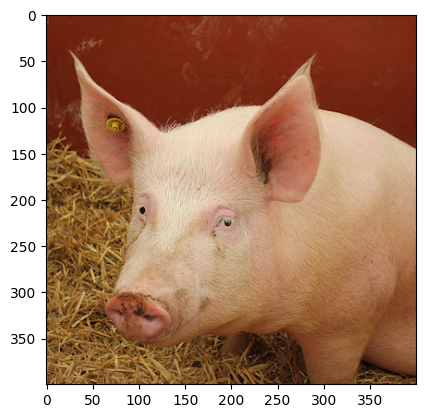

In [19]:
# Display the original image

pig_img = Image.open('pig.jpg')

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

pig_tensor = preprocess(pig_img)[None,:,:,:]


plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

plt.imshow(pig_img)
plt.show()


In [20]:
# Define the resnet model and normalize the picture
model = resnet50(pretrained=True)
model.eval()

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py

# Normalize input image
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Predicted probabilities for each class
pred = model(norm(pig_tensor))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
pred

tensor([[ 3.7593e+00,  3.2503e+00,  1.5318e+00,  2.0089e+00,  1.0908e+00,
          5.3037e+00,  2.8494e+00,  3.4273e+00,  3.3158e+00,  1.0625e+00,
         -1.0410e+00, -5.4555e-01, -1.2763e+00, -9.0664e-01, -1.4103e+00,
          1.9982e-01, -3.2718e+00, -2.2336e+00, -3.3918e-01, -5.3908e-01,
         -1.4594e+00, -3.2748e+00, -3.1585e+00,  1.2886e+00, -2.6868e+00,
          8.4224e-01,  1.2508e+00,  1.8760e+00,  1.7243e+00,  6.5247e+00,
         -6.9164e-01, -5.9965e-01,  1.4849e+00,  4.0206e+00,  3.2613e+00,
          1.2939e+00,  2.3770e+00,  1.4365e+00,  2.3621e+00, -8.6792e-01,
         -1.8666e+00, -4.1171e-02, -1.4949e+00, -8.8089e-02,  8.5850e-01,
          5.0927e-01, -1.9038e+00,  3.2701e+00,  7.5258e-01,  1.4365e+00,
          3.4213e-01,  4.5331e+00,  2.4282e+00, -1.2705e+00,  9.5924e-01,
         -1.5547e+00, -3.1129e-01, -7.0777e-01, -2.4607e+00, -1.4731e+00,
          5.5937e-01,  1.8268e+00,  8.5339e-01, -8.0821e-01, -5.6806e-01,
          2.5732e+00,  1.7862e+00, -4.

In [23]:
import json

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


In [ ]:
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


In [24]:
# epsilon = 2./255
epsilon = 2./500

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())


0 -0.003882253309711814
5 -0.006934741511940956
10 -0.015805913135409355
15 -0.07945683598518372
20 -6.113805294036865
25 -6.951679229736328
True class probability: 0.0009099571034312248


In [23]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())


Predicted class:  wombat
Predicted probability: 0.9971014857292175


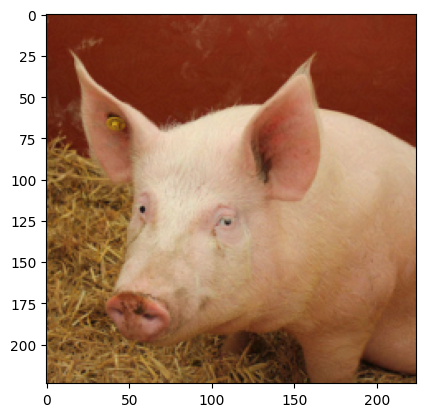

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

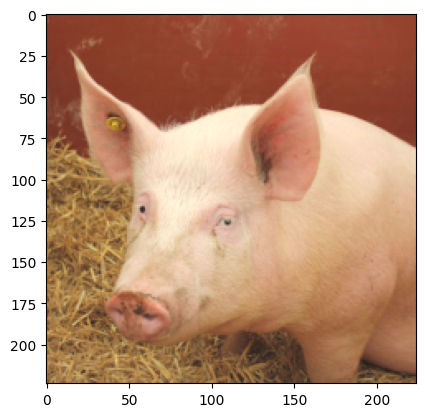

In [26]:
delta = 1/10
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))


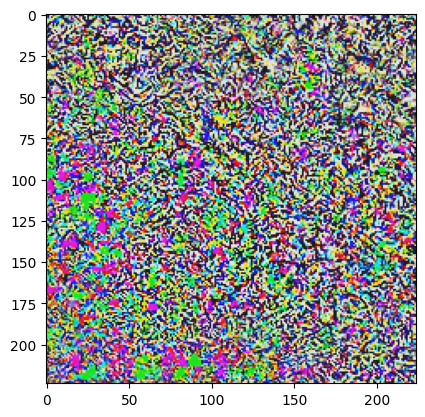

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [41]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)
epsilon = 2./255


for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)


0 24.00604820251465
10 -0.0806264877319336
20 -8.273968696594238
30 -14.132783889770508
40 -21.238550186157227
50 -27.0126953125
60 -30.517362594604492
70 -32.548892974853516
80 -35.45108413696289
90 -35.658687591552734


In [42]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.8762737512588501


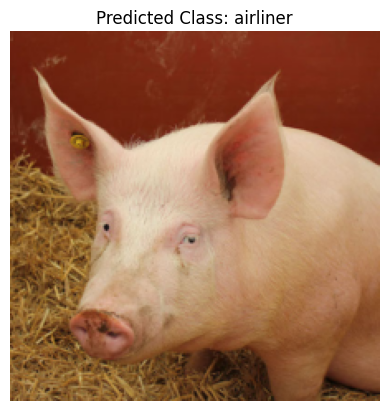

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming pig_tensor is your input image tensor
# Convert the tensor to a NumPy array
pig_image = pig_tensor.squeeze().cpu().detach().numpy()
pig_image = np.transpose(pig_image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

# Display the image
plt.imshow(pig_image)
plt.axis('off')

# Assuming max_class is the predicted class index
plt.title(f'Predicted Class: {imagenet_classes[max_class]}')
plt.show()


### Let's fool the model with a `banana`




In [29]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)
epsilon = 2./255


for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([954])))
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)


0 22.010854721069336
10 -4.607987403869629
20 -16.235563278198242
30 -28.152257919311523
40 -38.3276252746582
50 -46.25368881225586
60 -45.43109893798828
70 -54.548927307128906
80 -53.777748107910156
90 -56.11620330810547


In [30]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  banana
Predicted probability: 0.9999985694885254


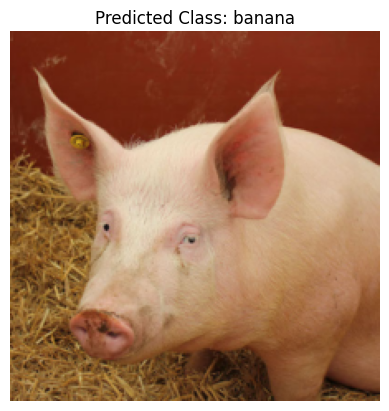

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming pig_tensor is your input image tensor
# Convert the tensor to a NumPy array
pig_image = pig_tensor.squeeze().cpu().detach().numpy()
pig_image = np.transpose(pig_image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

# Display the image
plt.imshow(pig_image)
plt.axis('off')

# Assuming max_class is the predicted class index
plt.title(f'Predicted Class: {imagenet_classes[max_class]}')
plt.show()


### Let's fool the model with an `ice cream`

In [25]:
epochs = 100
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)
epsilon = 2./255



for epoch in range(epochs):
  pred = model(norm(pig_tensor + delta))
  loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + nn.CrossEntropyLoss()(pred, torch.LongTensor([929])))
  if epoch%10 == 0:
    print(epoch, loss)

  opt.zero_grad()
  loss.backward()
  opt.step()
  delta.data.clamp_(-epsilon, epsilon)


0 tensor(19.2775, grad_fn=<AddBackward0>)
10 tensor(-3.8670, grad_fn=<AddBackward0>)
20 tensor(-14.9073, grad_fn=<AddBackward0>)
30 tensor(-32.3167, grad_fn=<AddBackward0>)
40 tensor(-38.6148, grad_fn=<AddBackward0>)
50 tensor(-57.7062, grad_fn=<AddBackward0>)
60 tensor(-76.8216, grad_fn=<AddBackward0>)
70 tensor(-73.8784, grad_fn=<AddBackward0>)
80 tensor(-75.1140, grad_fn=<AddBackward0>)
90 tensor(-89.2919, grad_fn=<AddBackward0>)


In [26]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  ice_lolly
Predicted probability: 1.0


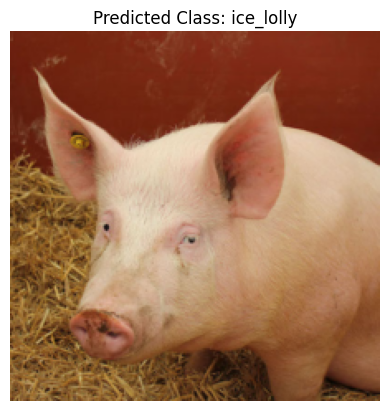

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming pig_tensor is your input image tensor
# Convert the tensor to a NumPy array
pig_image = pig_tensor.squeeze().cpu().detach().numpy()
pig_image = np.transpose(pig_image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

# Display the image
plt.imshow(pig_image)
plt.axis('off')

# Assuming max_class is the predicted class index
plt.title(f'Predicted Class: {imagenet_classes[max_class]}')
plt.show()
